In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/celeba/celebA_after_activation.h5
/kaggle/input/celeba/celebA_after_activation.pkl
/kaggle/input/aidence-data/train_images_np.pkl
/kaggle/input/aidence-data/test_images_np.pkl
/kaggle/input/adienceyage/y_age_test_one_hot.pkl
/kaggle/input/adienceyage/y_age_train_one_hot.pkl
/kaggle/input/adience-y/y_train_np.pkl
/kaggle/input/adience-y/y_test_np.pkl


In [ ]:
from tensorflow import keras

import tensorflow as tf
import pandas as pd
import PIL
import PIL.Image
import numpy as np
import pickle
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import load_model
from keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers.core import Dropout, Activation
from tensorflow.keras import layers

## Import Adience numpy array

In [ ]:
import pickle

path = '/kaggle/input/aidence-data/'
with open(path + 'train_images_np.pkl','rb') as f:
     train_images = pickle.load(f)

with open(path + 'test_images_np.pkl','rb') as f:
     test_images = pickle.load(f)
        
        
path = '/kaggle/input/adience-y/'
with open(path + 'y_train_np.pkl','rb') as f:
     y_train_one_hot = pickle.load(f)

with open(path + 'y_test_np.pkl','rb') as f:
     y_test_one_hot = pickle.load(f)
        
path = '/kaggle/input/adienceyage/'
with open(path + 'y_age_train_one_hot.pkl','rb') as f:
     y_age_train_np = pickle.load(f)

with open(path + 'y_age_test_one_hot.pkl','rb') as f:
     y_age_test_np = pickle.load(f)

print(train_images.shape)
print(test_images.shape)
print(y_train_one_hot.shape)
print(y_test_one_hot.shape)
print(y_age_train_np.shape)
print(y_age_test_np.shape)

(12216, 227, 227, 3)
(5236, 227, 227, 3)
(12216, 2)
(5236, 2)
(12216, 8)
(5236, 8)


## Transfer Learning

### Load Pre-trained model and remove last layer

In [ ]:
model_path = '/kaggle/input/celeba/celebA_after_activation.h5'

base_model = load_model(model_path)

base_model_no_top = Model(base_model.input, base_model.layers[-2].output)
base_model_no_top.summary()

2021-11-14 18:38:08.503626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 18:38:08.599134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 18:38:08.599843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 18:38:08.601748: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 227, 227, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 221, 221, 96)      14208     
_________________________________________________________________
batch_normalization (BatchNo (None, 221, 221, 96)      384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 96)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 106, 256)     614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 106, 106, 256)     1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 52, 52, 256)       0     

### Freeze the first 7 layers

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 7

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_no_top.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
# Let's take a look at the base model architecture
base_model_no_top.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 227, 227, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 221, 221, 96)      14208     
_________________________________________________________________
batch_normalization (BatchNo (None, 221, 221, 96)      384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 96)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 106, 256)     614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 106, 106, 256)     1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 52, 52, 256)       0     

In [ ]:
inputs = tf.keras.Input(shape=(227, 227, 3))
x = base_model_no_top(inputs, training=False)
prediction_layer = layers.Dense(2, activation='softmax', name='dense2')
outputs = prediction_layer(x)

In [ ]:
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 512)               115026304 
_________________________________________________________________
dense2 (Dense)               (None, 2)                 1026      
Total params: 115,027,330
Trainable params: 114,396,290
Non-trainable params: 631,040
_________________________________________________________________


### Introduce early stopping to ensure model does not overfit, since this dataset is very small compared to the celebA dataset

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
epochs=15

history = model.fit(train_images, y_train_one_hot, validation_data=(test_images, y_test_one_hot), epochs=epochs, batch_size=32, verbose=2, callbacks=[callback])

2021-11-14 18:38:23.342525: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1888434792 exceeds 10% of free system memory.
2021-11-14 18:38:25.299267: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1888434792 exceeds 10% of free system memory.
2021-11-14 18:38:26.952371: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2021-11-14 18:38:28.462675: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2021-11-14 18:39:00.847699: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 809417532 exceeds 10% of free system memory.
2021-11-14 18:39:01.733294: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 809417532 exceeds 10% of free system memory.


382/382 - 44s - loss: 0.5028 - accuracy: 0.7475 - val_loss: 0.3373 - val_accuracy: 0.8510
Epoch 2/15
382/382 - 30s - loss: 0.2411 - accuracy: 0.8982 - val_loss: 0.2681 - val_accuracy: 0.8875
Epoch 3/15
382/382 - 30s - loss: 0.1236 - accuracy: 0.9536 - val_loss: 0.3088 - val_accuracy: 0.8944
Epoch 4/15
382/382 - 30s - loss: 0.0620 - accuracy: 0.9796 - val_loss: 0.3894 - val_accuracy: 0.8951


### Unfreeze base model

In [ ]:
base_model_no_top.trainable = True
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 512)               115026304 
_________________________________________________________________
dense2 (Dense)               (None, 2)                 1026      
Total params: 115,027,330
Trainable params: 115,025,858
Non-trainable params: 1,472
_________________________________________________________________


### Fine tune with low learning rate

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

epochs=10

history = model.fit(train_images, y_train_one_hot, validation_data=(test_images, y_test_one_hot), epochs=epochs, batch_size=32, verbose=2, callbacks=[callback])

2021-11-14 18:40:40.615378: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1888434792 exceeds 10% of free system memory.


Epoch 1/10
382/382 - 67s - loss: 0.0318 - accuracy: 0.9904 - val_loss: 0.3864 - val_accuracy: 0.8959
Epoch 2/10
382/382 - 64s - loss: 0.0242 - accuracy: 0.9930 - val_loss: 0.3918 - val_accuracy: 0.8982
Epoch 3/10
382/382 - 64s - loss: 0.0205 - accuracy: 0.9944 - val_loss: 0.3999 - val_accuracy: 0.8971


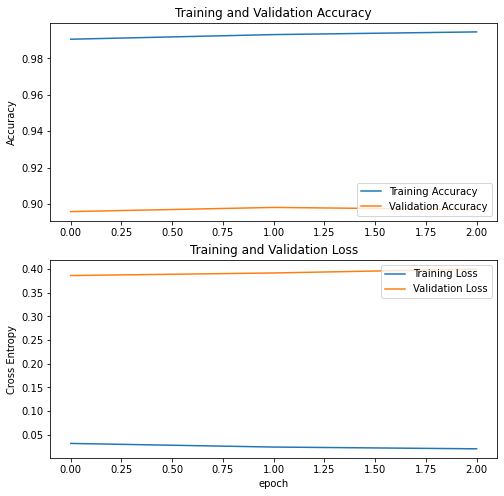

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Save Fine Tuned model

In [ ]:
# import pickle
# model.save('celebA_finetuned.h5')
# with open('celebA_finetuned.pkl','wb') as f:
#   pickle.dump(history.history, f) 

### Load Fine Tuned model

In [ ]:
# import pickle
# model_path = '/kaggle/input/celeba/celebA_finetuned.h5'

# model = load_model(model_path)

### Performance evaluation

In [ ]:
y_pred = model.predict(test_images)
proba = y_pred.max(axis=1).reshape(-1, 1)
y_proba_positive = y_pred[:,1:]
y_pred_one_hot = np.where(y_pred == proba, 1, 0)
y_pred_int = [np.where(r==1)[0][0] for r in y_pred_one_hot]

y_true = [np.where(r==1)[0][0] for r in y_test_one_hot]

### F1, Precision, Recall

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

In [ ]:
accuracy = accuracy_score(y_true, y_pred_int)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred_int)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred_int)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred_int)
print('F1 score: %f' % f1)

# ROC AUC
auc = roc_auc_score(y_true, y_proba_positive.flatten())
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_true, y_pred_int)
print(matrix)

Accuracy: 0.897059
Precision: 0.900041
Recall: 0.881621
F1 score: 0.890736
ROC AUC: 0.962833
[[2500  244]
 [ 295 2197]]


### Confusion Matrix - Train

In [ ]:
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred_int,num_classes=2).numpy()
con_mat

array([[2500,  244],
       [ 295, 2197]], dtype=int32)

In [ ]:
classes=['male','female']

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

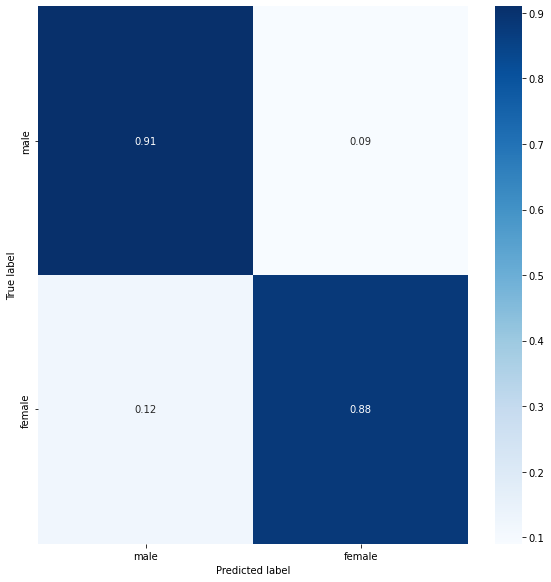

In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues,)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### ROC Curve

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr , tpr , thresholds = roc_curve (y_true , y_proba_positive.flatten())

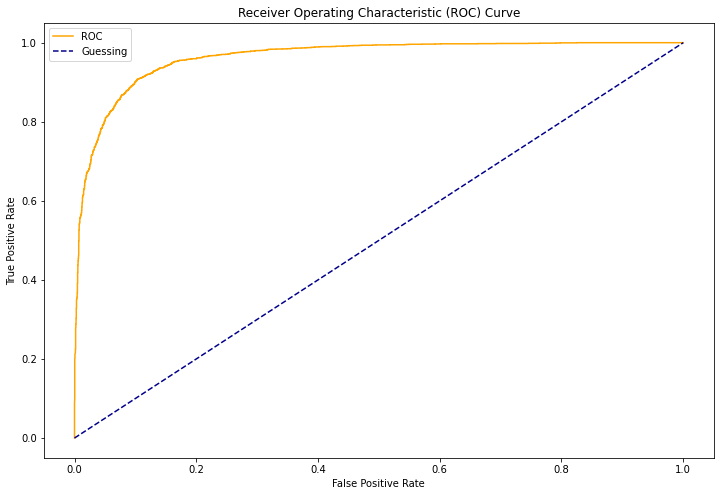

In [ ]:
def plot_roc_curve(fpr, tpr):
    """
    Plots a ROC curve given the false positve rate (fpr) and 
    true postive rate (tpr) of a classifier.
    """
    # Plot ROC curve
    figure = plt.figure(figsize=(12, 8))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    # Plot line with no predictive power (baseline)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Guessing')
    # Customize the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

plot_roc_curve(fpr, tpr)

### Accuracy against epoch

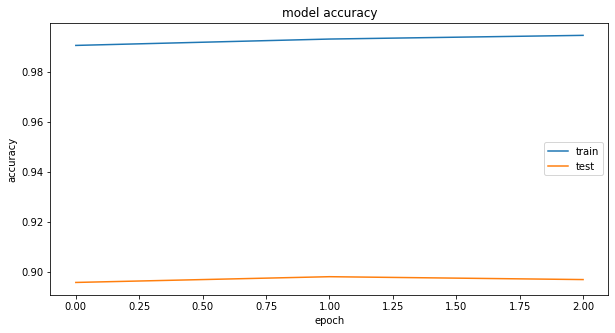

In [ ]:
# Plot accuracies of training and test data
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

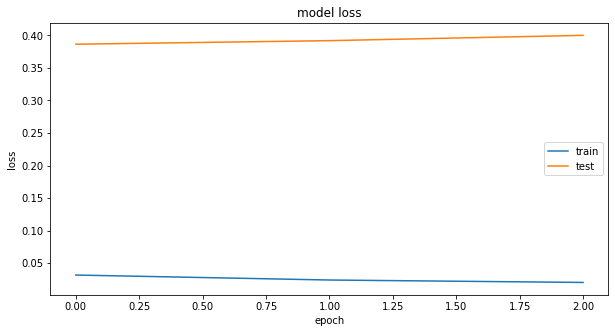

In [ ]:
# Plot losses of training and test data
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();